In [1]:
# Read here how to draw heatmap
# https://stackoverflow.com/questions/32485907/matplotlib-and-numpy-create-a-calendar-heatmap

from typing import Any, Union, Callable

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap

%matplotlib inline


DAYS = ['Mon.', 'Tues.', 'Wed.', 'Thurs.', 'Fri.', 'Sat.', 'Sun.']
MONTHS = ['Jan.', 'Feb.', 'Mar.', 'Apr.', 'May', 'June', 'July', 'Aug.', 'Sept.', 'Oct.', 'Nov.', 'Dec.']
CUSTOM_COLORMAP_NAME = 'dk_custom_colormap_red_green'

def make_date_heatmap(series, start=None, end=None, mean=False, ax=None, **kwargs):
    '''Plot a calendar heatmap given a datetime series.

    Arguments:
        series (pd.Series):
            A series of numeric values with a datetime index. Values occurring
            on the same day are combined by sum.
        start (Any):
            The first day to be considered in the plot. The value can be
            anything accepted by :func:`pandas.to_datetime`. The default is the
            earliest date in the data.
        end (Any):
            The last day to be considered in the plot. The value can be
            anything accepted by :func:`pandas.to_datetime`. The default is the
            latest date in the data.
        mean (bool):
            Combine values occurring on the same day by mean instead of sum.
        ax (matplotlib.Axes or None):
            The axes on which to draw the heatmap. The default is the current
            axes in the :module:`~matplotlib.pyplot` API.
        **kwargs:
            Forwarded to :meth:`~matplotlib.Axes.pcolormesh` for drawing the
            heatmap.

    Returns:
        matplotlib.collections.Axes:
            The axes on which the heatmap was drawn. This is set as the current
            axes in the `~matplotlib.pyplot` API.
    '''
    # Combine values occurring on the same day.
    dates = series.index.floor('D')
    group = series.groupby(dates)
    series = group.mean() if mean else group.sum()

    # Parse start/end, defaulting to the min/max of the index.
    start = pd.to_datetime(start or series.index.min())
    end = pd.to_datetime(end or series.index.max())

    # We use [start, end) as a half-open interval below.
    end += np.timedelta64(1, 'D')

    # Get the previous/following Sunday to start/end.
    # Pandas and numpy day-of-week conventions are Monday=0 and Sunday=6.
    start_sun = start - np.timedelta64((start.dayofweek + 1) % 7, 'D')
    end_sun = end + np.timedelta64(7 - end.dayofweek - 1, 'D')

    # Create the heatmap and track ticks.
    num_weeks = (end_sun - start_sun).days // 7
    heatmap = -1 * np.ones((7, num_weeks)) # -1 is default N/A value

    ticks = {}  # week number -> month name
    for week in range(num_weeks):
        for day in range(7):
            date = start_sun + np.timedelta64(7 * week + day, 'D')
            if date.day == 1:
                ticks[week] = MONTHS[date.month - 1]
            if date.dayofyear == 1:
                ticks[week] += f'\n{date.year}'
            if start <= date < end:
                heatmap[day, week] = series.get(date, 0)

    # Get the coordinates, offset by 0.5 to align the ticks.
    y = np.arange(8) - 0.5
    x = np.arange(num_weeks + 1) - 0.5

    # Plot the heatmap. Prefer pcolormesh over imshow so that the figure can be
    # vectorized when saved to a compatible format. We must invert the axis for
    # pcolormesh, but not for imshow, so that it reads top-bottom, left-right.
    ax = ax or plt.gca()
    mesh = ax.pcolormesh(x, y, heatmap, **kwargs)
    ax.invert_yaxis()

    # Set the ticks
    ax.set_xticks(list(ticks.keys()))
    ax.set_xticklabels(list(ticks.values()))
    ax.set_yticks(np.arange(7))
    ax.set_yticklabels(DAYS)

    # Set the current image and axes in the pyplot API.
    plt.sca(ax)
    plt.sci(mesh)

    return ax

def load_data_from_cvs(
        filename: str,
        value_column_name: str, 
        date_column_name: str = 'Date', 
        value_mapping_dict: Union[dict[str, Any], None] = None) -> pd.DataFrame:
    """Loads data from CSV file. Extract data from defined column and apply map to values

    Args:
        file_name (str): filename
        value_column_name (str): which column use to make dashboard 
        date_column_name (str, optional): which column contains dates. Defaults to 'Date'.
        value_mapping_dict (Union[dict[str, Any], None], optional): Aplay map(value_mapping_dict) for df[column_name] if is not None. Defaults to None.

    Returns:
        pd.DataFrame: Pandas DataFrame to make dashboard of.
    """

    df = pd.read_csv(filename)
    data = df[value_column_name]
    if value_mapping_dict is not None:
        data = data.map(value_mapping_dict)

    data.index = pd.to_datetime(df[date_column_name])

    # Uncomment 3 lines below to fill data with random values
    # data = np.random.randint(2, size=365)
    # data = pd.Series(data)
    # data.index = pd.date_range(start='2022-01-01', end='2022-12-31', freq='1D')

    return data

def draw_heatmap(data: pd.DataFrame, 
                color_map_name: str, 
                result_pdf_filename: str = None,
                color_map = None,
                y_labels_format_function: Callable = None,
                title: str = None):
    '''An example for `date_heatmap`.

    Most of the sizes here are chosen arbitrarily to look nice with 1yr of
    data. You may need to fiddle with the numbers to look right on other data.
    '''

    # Create the figure. For the aspect ratio, one year is 7 days by 53 weeks.
    # We widen it further to account for the tick labels and color bar.
    figsize = plt.figaspect(7 / 56)
    fig = plt.figure(figsize=figsize)

    # Plot the heatmap with a color bar.
    ax = make_date_heatmap(data, edgecolor='black')
    plt.colorbar(ticks=range(-1, 2), pad=0.02, format=y_labels_format_function)
    # plt.ax.set_yticklabels(['bad', 'good'])  # vertically oriented colorbar
    
    if color_map is not None:
        plt.register_cmap(cmap=color_map) # register new colormap

    plt.set_cmap(color_map_name)
    # plt.clim(-0.5, 4.5)

    # Force the cells to be square. If this is set, the size of the color bar
    # may look weird compared to the size of the heatmap. That can be corrected
    # by the aspect ratio of the figure or scale of the color bar.
    ax.set_aspect('equal')

    # Save to a file. For embedding in a LaTeX doc, consider the PDF backend.
    # http://sbillaudelle.de/2015/02/23/seamlessly-embedding-matplotlib-output-into-latex.html

    plt.title(title)
    if result_pdf_filename is not None:
        fig.savefig(result_pdf_filename, bbox_inches='tight')

    plt.show()
    
    # The firgure must be explicitly closed if it was not shown.
    plt.close(fig)

def fmt(x, pos):
    """Maps description to values of heatmap

    Args:
        x (_type_): _description_
        pos (_type_): _description_

    Returns:
        _type_: _description_
    """        

    legend = {-1: 'unknown',
            0: 'bad',
            1: 'good'}
    return legend[x]

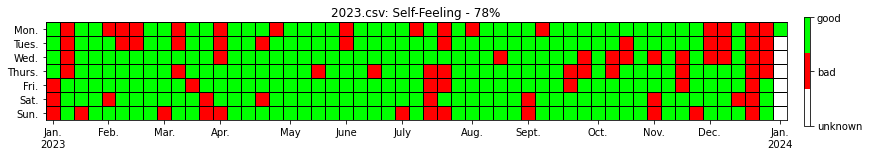

/var/folders/9m/tth9zlt910549vvdqgrwg7rh0000gn/T/ipykernel_89563/691680210.py:159: UserWarning: Trying to register the cmap 'dk_custom_colormap_red_green' which already exists.
  plt.register_cmap(cmap=color_map) # register new colormap


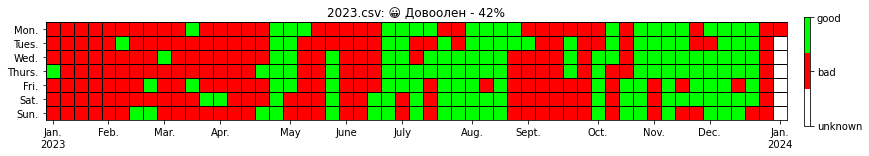

/var/folders/9m/tth9zlt910549vvdqgrwg7rh0000gn/T/ipykernel_89563/691680210.py:159: UserWarning: Trying to register the cmap 'dk_custom_colormap_red_green' which already exists.
  plt.register_cmap(cmap=color_map) # register new colormap
/var/folders/9m/tth9zlt910549vvdqgrwg7rh0000gn/T/ipykernel_89563/691680210.py:174: UserWarning: Glyph 128104 (\N{MAN}) missing from current font.
  fig.savefig(result_pdf_filename, bbox_inches='tight')
/var/folders/9m/tth9zlt910549vvdqgrwg7rh0000gn/T/ipykernel_89563/691680210.py:174: UserWarning: Glyph 128187 (\N{PERSONAL COMPUTER}) missing from current font.
  fig.savefig(result_pdf_filename, bbox_inches='tight')
/Users/sournk/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128104 (\N{MAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/sournk/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128187 (\N{PERSONAL COMPUTER}) missing from c

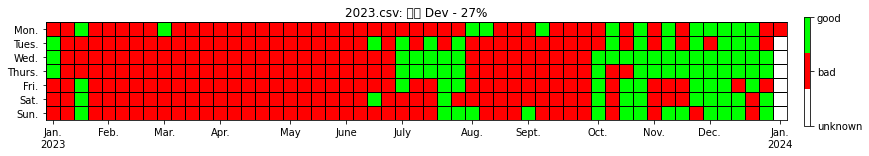

/var/folders/9m/tth9zlt910549vvdqgrwg7rh0000gn/T/ipykernel_89563/691680210.py:159: UserWarning: Trying to register the cmap 'dk_custom_colormap_red_green' which already exists.
  plt.register_cmap(cmap=color_map) # register new colormap
/var/folders/9m/tth9zlt910549vvdqgrwg7rh0000gn/T/ipykernel_89563/691680210.py:174: UserWarning: Glyph 129361 (\N{AVOCADO}) missing from current font.
  fig.savefig(result_pdf_filename, bbox_inches='tight')
/Users/sournk/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129361 (\N{AVOCADO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


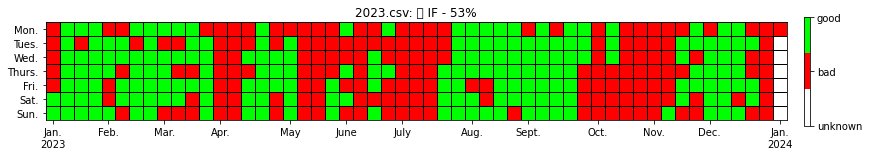

/var/folders/9m/tth9zlt910549vvdqgrwg7rh0000gn/T/ipykernel_89563/691680210.py:159: UserWarning: Trying to register the cmap 'dk_custom_colormap_red_green' which already exists.
  plt.register_cmap(cmap=color_map) # register new colormap
/var/folders/9m/tth9zlt910549vvdqgrwg7rh0000gn/T/ipykernel_89563/691680210.py:174: UserWarning: Glyph 128692 (\N{BICYCLIST}) missing from current font.
  fig.savefig(result_pdf_filename, bbox_inches='tight')
/Users/sournk/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128692 (\N{BICYCLIST}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


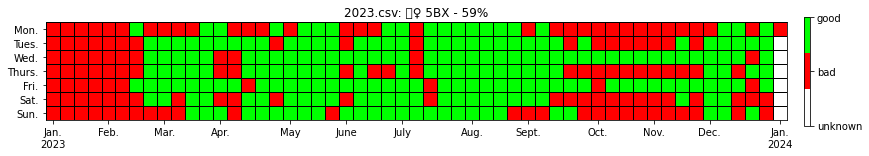

/var/folders/9m/tth9zlt910549vvdqgrwg7rh0000gn/T/ipykernel_89563/691680210.py:159: UserWarning: Trying to register the cmap 'dk_custom_colormap_red_green' which already exists.
  plt.register_cmap(cmap=color_map) # register new colormap


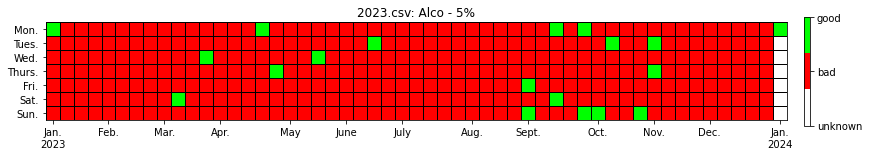

In [2]:
FILE_NAME = '2023.csv'
columns_list = ['Self-Feeling', '😀 Довоолен', '👨‍💻 Dev', '🥑 IF', '🚴‍♀️ 5BX', 'Alco']

for column_name in columns_list:
  data = load_data_from_cvs(filename=FILE_NAME,
                            value_column_name=column_name,
                            date_column_name='Date',
                            value_mapping_dict=dict(Yes=1, No=0))

  custom_color_map = LinearSegmentedColormap.from_list(CUSTOM_COLORMAP_NAME,
                                                      [(0, '#fff'),
                                                        (0.5, '#ff0000'),
                                                          (1,   '#00ff00')], N=3)

  title = f'{FILE_NAME}: {column_name} - {data.sum() / len(data):.0%}'
  draw_heatmap(data=data,
              result_pdf_filename=f'{FILE_NAME}_{column_name}.pdf',
              color_map=custom_color_map,
              color_map_name=CUSTOM_COLORMAP_NAME,
              y_labels_format_function=fmt,
              title=title)